In [1]:
import artm.messages_pb2, artm.library, sys, glob, os

### Парсим данные ММРО-ИОИ: vocab, docword и cooc в расширенном UCI-формате.

In [8]:
parser_config = artm.messages_pb2.CollectionParserConfig()
parser_config.format = 3  # Cooccurrences
parser_config.dictionary_file_name = 'cooc_dictionary'
parser_config.docword_file_path = '../datasets/mmro/cooc.mmro.txt'
parser_config.vocab_file_path = '../datasets/mmro/vocab.mmro.txt'
parser_config.target_folder = '../datasets/mmro'
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

In [3]:
parser_config.format = artm.library.CollectionParserConfig_Format_BagOfWordsUci  # Cooccurrences
parser_config.dictionary_file_name = 'dictionary'
parser_config.docword_file_path = '../datasets/mmro/docword.mmro.txt'
parser_config.vocab_file_path = '../datasets/mmro/vocab.mmro.txt'
parser_config.target_folder = '../datasets/mmro'
parser_config.num_items_per_batch = 100
artm.library.Library().ParseCollection(collection_parser_config = parser_config)

### Обучаем модель с предметными и фоновыми темами в интерфейсе ARTM.

In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt

import artm

In [2]:
batch_vectorizer = artm.BatchVectorizer(data_path='../datasets/mmro', data_format='batches')

In [3]:
background_topics = []
domain_topics = []
all_topics = []

for i in range(0, 30):
    topic_name = "topic" + str(i)
    all_topics.append(topic_name)
    if i < 25:
        domain_topics.append(topic_name)
    else:
        background_topics.append(topic_name)

In [4]:
model = artm.ARTM(topic_names = all_topics) 
# число внутренних проходов логичнее было бы видеть параметром в fit

In [5]:
model.load_dictionary(dictionary_name='dictionary', dictionary_path='../datasets/mmro/dictionary')
model.initialize(dictionary_name='dictionary')

model.load_dictionary(dictionary_name='cooc_dictionary', dictionary_path='../datasets/mmro/cooc_dictionary')

In [6]:
model.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                      use_unigram_document_model=False, # где-то сохраняется, сколько раз pwd = 0?
                                      dictionary_name='dictionary'))

model.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', 
                                       topic_names = domain_topics))

model.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore', 
                                        topic_names = domain_topics))

model.scores.add(artm.TopTokensScore(name='DomainTop10TokensScore', 
                                     num_tokens=10, 
                                     dictionary_name = 'cooc_dictionary',
                                     topic_names = domain_topics))

model.scores.add(artm.TopTokensScore(name='DomainTop100TokensScore', 
                                     num_tokens=100, 
                                     dictionary_name = 'cooc_dictionary',
                                     topic_names = domain_topics))

model.scores.add(artm.TopTokensScore(name='BackgroundTopTokensScore', 
                                     num_tokens=10, 
                                     topic_names = background_topics))

model.scores.add(artm.TopicKernelScore(name='DomainTopicKernelScore', 
                                       probability_mass_threshold=0.3, 
                                       dictionary_name = 'cooc_dictionary',
                                       topic_names = domain_topics))

model.scores.add(artm.TopicKernelScore(name='BackgroundTopicKernelScore', 
                                       probability_mass_threshold=0.3, 
                                       topic_names = background_topics))

# как посмотреть, какая доля коллекции отнесена к фоновым темам?

In [7]:
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SmoothTheta', tau=0.5, topic_names=background_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SmoothPhi', tau=0.5, topic_names=background_topics))
model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1e+4, topic_names=domain_topics))

In [8]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)
# хочется иметь возможность поставить reuse_theta=True и быть уверенным, что внутри реализован оффлайновый алгоритм

In [9]:
model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.5, topic_names=domain_topics))
model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.5, topic_names=domain_topics))

In [10]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=20)
# хочется уметь делать неконстантные траектории регуляризации

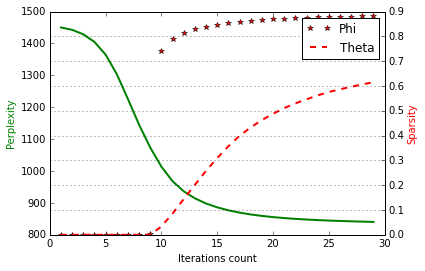

In [11]:
x = range(model.num_phi_updates)[1:]
fig, ax1 = plt.subplots()
ax1.plot(x, model.score_tracker['PerplexityScore'].value[1:], 'g-', linewidth=2, label="Perplexity")
ax1.set_xlabel('Iterations count')
ax1.set_ylabel('Perplexity', color='g')

ax2 = ax1.twinx()
ax2.plot(x, model.score_tracker['SparsityPhiScore'].value[1:], 'r*', linewidth=2, label="Phi")
ax2.plot(x, model.score_tracker['SparsityThetaScore'].value[1:], 'r--', linewidth=2, label="Theta")
ax2.set_ylabel('Sparsity', color='r')
ax2.legend()
plt.grid(True)
plt.show()

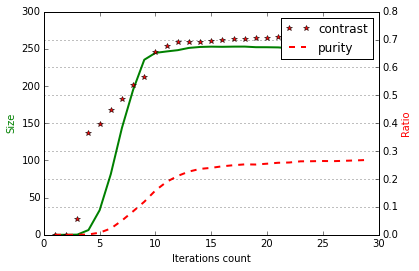

In [12]:
x = range(model.num_phi_updates)[1:]
fig, ax1 = plt.subplots()
ax1.plot(x, model.score_tracker['DomainTopicKernelScore'].average_size[1:], 'g-', linewidth=2, label="size")
ax1.set_xlabel('Iterations count')
ax1.set_ylabel('Size', color='g')

ax2 = ax1.twinx()
ax2.plot(x, model.score_tracker['DomainTopicKernelScore'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
ax2.plot(x, model.score_tracker['DomainTopicKernelScore'].average_purity[1:], 'r--', linewidth=2, label="purity")
ax2.set_ylabel('Ratio', color='r')
ax2.legend()
plt.grid(True)
plt.show()

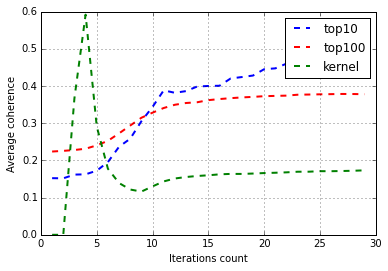

In [13]:
x = range(model.num_phi_updates)[1:]
plt.plot(x, model.score_tracker['DomainTop10TokensScore'].average_coherence[1:], 'b--', label="top10", linewidth=2)
plt.plot(x, model.score_tracker['DomainTop100TokensScore'].average_coherence[1:], 'r--', label="top100", linewidth=2)
plt.plot(x, model.score_tracker['DomainTopicKernelScore'].average_coherence[1:], 'g--', label="kernel", linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('Average coherence')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
for topic_name in domain_topics:
    print topic_name + ': ',
    tokens = model.score_tracker['DomainTop10TokensScore'].last_topic_info[topic_name].tokens
    for token in tokens:
        print token,
    print

topic0:  объект класс классификация признак описание который задача каждый эталон алгоритм
topic1:  изображение признак кластер поиск пиксель алгоритм дать анализ вектор качество
topic2:  алгоритм ошибка выборка оценка обучение вероятность метод переобучение семейство множество
topic3:  система множество понятие формальный оператор измерение который таблица быть контекст
topic4:  задача решение вектор алгоритм множество число последовательность подмножество анализ дать
topic5:  алгоритм параметр множество построение значение который представление быть уровень класс
topic6:  точка быть задача пространство решение окрестность размерность который разметка свойство
topic7:  функция выборка оценка объект задача обучать метод вектор быть совокупность
topic8:  закономерность переменный метод значение ряд набор задача логический анализ число
topic9:  скелет точка фигура изображение ребро граница вершина круг быть который
topic10:  документ текст слово метод быть пользователь который дать качес

In [15]:
for topic_name in background_topics:
    print topic_name + ': ',
    tokens = model.score_tracker['BackgroundTopTokensScore'].last_topic_info[topic_name].tokens
    for token in tokens:
        print token,
    print

topic25:  система поток который дать объект быть сеть состояние изображение цветовой
topic26:  система дать технология знание модель работа интеллектуальный решение который анализ
topic27:  мозг быть число идеальный дать дефект метод эксперимент математика трёхмерный
topic28:  алгоритм дать число работа потеря прогноз прогнозирование время товар процессор
topic29:  анализ цена управление система который решение рынок метод экономический показатель
